<a href="https://colab.research.google.com/github/hhn20/models/blob/master/OneShotSiamese.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import statements and data preperation

In [ ]:
import numpy as np
import pandas as pd
import os
from PIL import Image 
import matplotlib.pyplot as plt
import random
import cv2
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import seaborn as sns
from collections import Counter

import tensorflow as tf
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras import backend as K
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Flatten, Dense, Concatenate, Dot, Lambda, Input, Dropout, Conv1D, Conv2D, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.applications.resnet50 import ResNet50


>Creating list of images and labels (each folder in the dataset is taken as a class)



In [ ]:
base="/content/drive/MyDrive/dataset"
c=0
x=[]
y=[]
class_names = []
SIZE = 224
for folder in os.listdir(base):
  class_names.append(folder)
  for pic in os.listdir(base+"/"+folder):
    img=Image.open(base+"/"+folder+"/"+pic)
    img=img.resize((SIZE,SIZE))
    x+=[np.array(img)]
    y+=[c]
  c+=1   
x=np.array(x)
y=np.array(y)

In [ ]:
print("shape of image list x =",x.shape) 
print("shape of class list y =",y.shape)

shape of image list x = (75, 224, 224, 3)
shape of class list y = (75,)


> Making pairs of images along with label to feed into Siamese network

In [ ]:
def make_pairs(x, y):
    num_classes = len(os.listdir(base))
    digit_indices = [np.where(y == i)[0] for i in range(num_classes)]
    print(digit_indices)
    pairs = []
    labels = []
    for idx1 in range(len(x*2)):
        # add a matching example
        x1 = x[idx1]
        label1 = y[idx1]
        idx2 = random.choice(digit_indices[label1])
        x2 = x[idx2]
        
        pairs += [[x1, x2]]
        labels += [1]
    
        # add a not matching example
        label2 = random.randint(0, num_classes-1)
        while label2 == label1:
            label2 = random.randint(0, num_classes-1)

        idx2 = random.choice(digit_indices[label2])
        x2 = x[idx2]
        
        pairs += [[x1, x2]]
        labels += [0]
        

    return np.array(pairs), np.array(labels)

In [ ]:
pairs_x,pairs_y=make_pairs(x,y)

[array([0, 1, 2, 3, 4, 5, 6, 7, 8]), array([ 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]), array([20, 21, 22, 23, 24, 25, 26, 27, 28, 29]), array([30, 31, 32, 33, 34, 35, 36, 37]), array([38, 39, 40, 41, 42, 43, 44, 45, 46]), array([47, 48, 49, 50, 51, 52, 53, 54]), array([55, 56, 57, 58, 59, 60, 61, 62, 63, 64]), array([65, 66, 67, 68, 69, 70, 71, 72, 73, 74])]


In [ ]:
print("shape of image pairs array is",pairs_x.shape)
print("shape of labels array is",pairs_y.shape)

shape of image pairs array is (150, 2, 224, 224, 3)
shape of labels array is (150,)


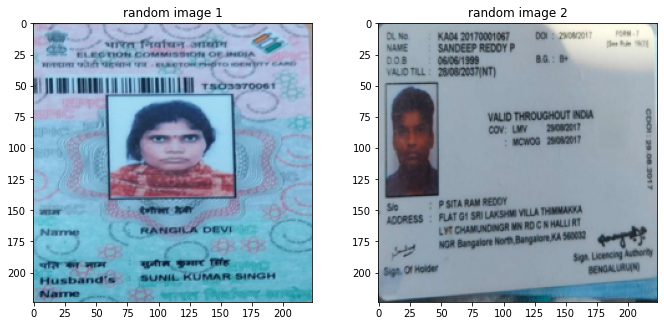

label for this pair is 0


In [ ]:
rand = random.randrange(0, pairs_x.shape[0], 1)
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
fig.tight_layout(pad=3)
ax[0].imshow(pairs_x[rand][0])
ax[0].set(title='random image 1')
ax[1].imshow(pairs_x[rand][1])
ax[1].set(title='random image 2')
plt.show()
print("label for this pair is",pairs_y[rand])

> Splitting the dataset into training and testing sets



In [ ]:
pairs_train_x, pairs_test_x, pairs_train_y, pairs_test_y = train_test_split(pairs_x,pairs_y, test_size=0.33, random_state=5,stratify=pairs_y)

In [ ]:
print("training set shape:",pairs_train_x.shape)
print("training set labels shape:",pairs_train_x.shape)
X=x
Y=y

training set shape: (100, 2, 224, 224, 3)
training set labels shape: (100, 2, 224, 224, 3)


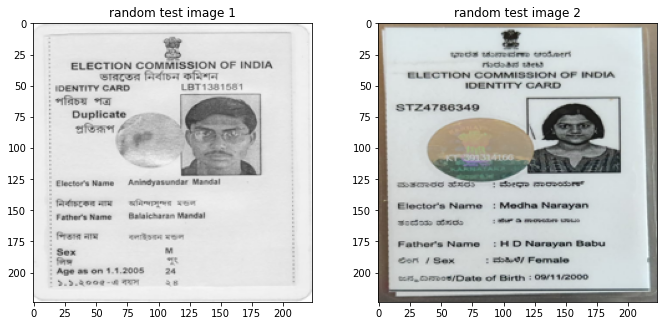

label for this test pair is 1


In [ ]:
rand = random.randrange(0, pairs_test_x.shape[0], 1)
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
fig.tight_layout(pad=3)
ax[0].imshow(pairs_test_x[rand][0])
ax[0].set(title='random test image 1')
ax[1].imshow(pairs_test_x[rand][1])
ax[1].set(title='random test image 2')
plt.show()
print("label for this test pair is",pairs_test_y[rand])

> **Cosine Similarity between Embeddings(vectors)**

In [ ]:
def cosine_similarity(vects):
  x, y = vects
  dotxy = Dot(axes=1)([x, y])
  magx  = K.sqrt(Dot(axes=1)([x,x]))
  magy  = K.sqrt(Dot(axes=1)([y,y]))
  return (dotxy/(magx*magy))

In [ ]:
cosine_similarity([tf.constant([[1.9,1.8]]),tf.constant([[1.9,1.9]])])

<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[0.9996349]], dtype=float32)>

# Initial trial Model

In [ ]:
input = Input((SIZE,SIZE,3))
x = Flatten()(input)
x = Dense(28, activation='relu')(x)
x = Dense(52, activation='relu')(x)
dense = Model(input, x)


input1 = Input((SIZE,SIZE,3))
input2 = Input((SIZE,SIZE,3))

dense1 = dense(input1)
dense2 = dense(input2)

output_layer = Lambda(cosine_similarity)([dense1,dense2])
model = Model(inputs=[input1, input2], outputs=output_layer)

In [ ]:
model.compile(loss = "binary_crossentropy", optimizer="adam", metrics=["accuracy"])
model.summary()

Model: "model_17"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_26 (InputLayer)           [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
input_27 (InputLayer)           [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
model_16 (Functional)           (None, 52)           4216320     input_26[0][0]                   
                                                                 input_27[0][0]                   
__________________________________________________________________________________________________
lambda_8 (Lambda)               (None, 1)            0           model_16[0][0]            

In [ ]:
a=pairs_train_x[:,0]
b=pairs_train_x[:,1]
c=pairs_test_x[:,0]
d=pairs_test_x[:,1]
history=model.fit([a,b], pairs_train_y,batch_size=50, epochs= 5, validation_data=([c,d], pairs_test_y))

Epoch 1/5
2/2 [==============================] - 1s 277ms/step - loss: 2.1189 - accuracy: 0.4867 - val_loss: 3.4264 - val_accuracy: 0.5000
Epoch 2/5
2/2 [==============================] - 0s 64ms/step - loss: 3.1299 - accuracy: 0.4933 - val_loss: 3.0666 - val_accuracy: 0.5000
Epoch 3/5
2/2 [==============================] - 0s 66ms/step - loss: 2.8164 - accuracy: 0.4933 - val_loss: 2.8525 - val_accuracy: 0.5000
Epoch 4/5
2/2 [==============================] - 0s 69ms/step - loss: 2.5351 - accuracy: 0.5000 - val_loss: 2.6824 - val_accuracy: 0.5000
Epoch 5/5
2/2 [==============================] - 0s 65ms/step - loss: 2.1475 - accuracy: 0.5400 - val_loss: 2.5368 - val_accuracy: 0.5000


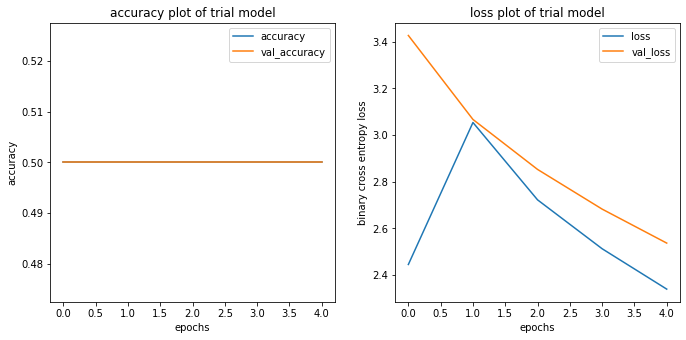

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
fig.tight_layout(pad=3)
ax[0].plot(history.history['accuracy'])
ax[0].plot(history.history['val_accuracy'])
ax[0].legend(['accuracy', 'val_accuracy'])
ax[0].set(title='accuracy plot of trial model', ylabel='accuracy', xlabel='epochs')
ax[1].plot(history.history['loss'])
ax[1].plot(history.history['val_loss'])
ax[1].legend(['loss', 'val_loss'])
ax[1].set(title='loss plot of trial model', ylabel='binary cross entropy loss', xlabel='epochs')
plt.show()

# VGG16 based Transfer Learning Model

In [ ]:
input1 = Input((SIZE,SIZE,3))
input2 = Input((SIZE,SIZE,3))
base_model = VGG16(weights='imagenet',input_shape=(SIZE, SIZE, 3), include_top=False)
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
x = Dense(512, activation='sigmoid')(x)
# x = Dense(256, activation='sigmoid')(x)
for layer in base_model.layers:
    layer.trainable = False
vgg_model = Model(inputs=base_model.input, outputs=x)

vgg_encoded1 = vgg_model(input1)
vgg_encoded2 = vgg_model(input2)
    
output_layer = Lambda(cosine_similarity)([vgg_encoded1,vgg_encoded2])
siamese_net_1 = Model(inputs=[input1,input2],outputs=output_layer)

In [ ]:
siamese_net_1.compile(loss = "binary_crossentropy", optimizer="adam", metrics=["accuracy"])
siamese_net_1.summary()

Model: "model_19"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_28 (InputLayer)           [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
input_29 (InputLayer)           [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
model_18 (Functional)           (None, 512)          15764800    input_28[0][0]                   
                                                                 input_29[0][0]                   
__________________________________________________________________________________________________
lambda_9 (Lambda)               (None, 1)            0           model_18[0][0]            

In [ ]:
a=pairs_train_x[:,0]
b=pairs_train_x[:,1]
c=pairs_test_x[:,0]
d=pairs_test_x[:,1]
history=siamese_net_1.fit([a,b], pairs_train_y,batch_size=50, epochs= 25, validation_data=([c,d], pairs_test_y))

Epoch 1/25
2/2 [==============================] - 4s 2s/step - loss: 1.2511 - accuracy: 0.4800 - val_loss: 0.7831 - val_accuracy: 0.5000
Epoch 2/25
2/2 [==============================] - 2s 2s/step - loss: 0.6764 - accuracy: 0.5400 - val_loss: 0.5288 - val_accuracy: 0.6800
Epoch 3/25
2/2 [==============================] - 2s 2s/step - loss: 0.3835 - accuracy: 0.8267 - val_loss: 0.4054 - val_accuracy: 0.7800
Epoch 4/25
2/2 [==============================] - 2s 2s/step - loss: 0.2668 - accuracy: 0.9467 - val_loss: 0.3482 - val_accuracy: 0.8200
Epoch 5/25
2/2 [==============================] - 2s 2s/step - loss: 0.1821 - accuracy: 0.9933 - val_loss: 0.2864 - val_accuracy: 0.8800
Epoch 6/25
2/2 [==============================] - 2s 2s/step - loss: 0.1119 - accuracy: 0.9933 - val_loss: 0.2357 - val_accuracy: 0.9600
Epoch 7/25
2/2 [==============================] - 2s 2s/step - loss: 0.0925 - accuracy: 1.0000 - val_loss: 0.1934 - val_accuracy: 0.9600
Epoch 8/25
2/2 [=========================

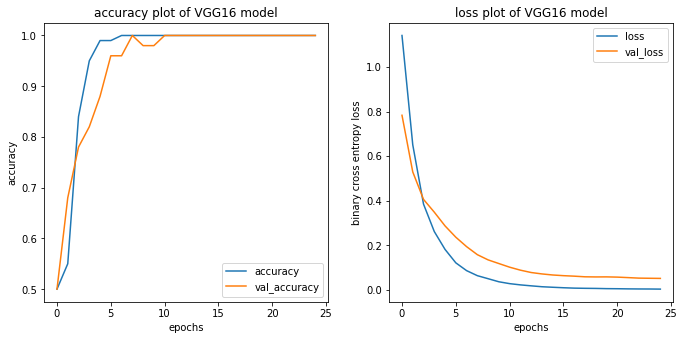

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
fig.tight_layout(pad=3)
ax[0].plot(history.history['accuracy'])
ax[0].plot(history.history['val_accuracy'])
ax[0].legend(['accuracy', 'val_accuracy'])
ax[0].set(title='accuracy plot of VGG16 model', ylabel='accuracy', xlabel='epochs')
ax[1].plot(history.history['loss'])
ax[1].plot(history.history['val_loss'])
ax[1].legend(['loss', 'val_loss'])
ax[1].set(title='loss plot of VGG16 model', ylabel='binary cross entropy loss', xlabel='epochs')
plt.show()

In [ ]:
y_hat=[]
y=[]
for i in range(len(pairs_test_x)):
    a=siamese_net_1.predict([np.expand_dims(pairs_test_x[i][0],axis=0),np.expand_dims(pairs_test_x[i][1],axis=0)])
    if a[0][0]>0.5:
      y_hat.append(1)
    else:
      y_hat.append(0)
    y+=[pairs_test_y[i]]
print("accuracy of VGG16 model is",accuracy_score(y_hat,y))

accuracy of VGG16 model is 1.0


# ResNet50 based Transfer Learning Model

In [ ]:
input1 = Input((SIZE,SIZE,3))
input2 = Input((SIZE,SIZE,3))
base_model = ResNet50(weights='imagenet',input_shape=(SIZE, SIZE, 3), include_top=False)
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='sigmoid')(x)
x = Dense(512, activation='sigmoid')(x)
for layer in base_model.layers:
    layer.trainable = False
resnet_model = Model(inputs=base_model.input, outputs=x)

resnet_encoded1 = resnet_model(input1)
resnet_encoded2 = resnet_model(input2)
    
output_layer = Lambda(cosine_similarity)([resnet_encoded1,resnet_encoded2])
siamese_net_2 = Model(inputs=[input1,input2],outputs=output_layer)

In [ ]:
siamese_net_2.compile(loss = "binary_crossentropy", optimizer="adam", metrics=["accuracy"])
siamese_net_2.summary()

Model: "model_21"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_31 (InputLayer)           [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
input_32 (InputLayer)           [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
model_20 (Functional)           (None, 512)          26210688    input_31[0][0]                   
                                                                 input_32[0][0]                   
__________________________________________________________________________________________________
lambda_10 (Lambda)              (None, 1)            0           model_20[0][0]            

In [ ]:
a=pairs_train_x[:,0]
b=pairs_train_x[:,1]
c=pairs_test_x[:,0]
d=pairs_test_x[:,1]
history=siamese_net_2.fit([a,b], pairs_train_y,batch_size=50, epochs= 25, validation_data=([c,d], pairs_test_y))

Epoch 1/25
2/2 [==============================] - 10s 3s/step - loss: 2.6918 - accuracy: 0.5067 - val_loss: 1.8882 - val_accuracy: 0.5000
Epoch 2/25
2/2 [==============================] - 2s 1s/step - loss: 1.7253 - accuracy: 0.5000 - val_loss: 1.3051 - val_accuracy: 0.5000
Epoch 3/25
2/2 [==============================] - 2s 1s/step - loss: 1.1967 - accuracy: 0.4867 - val_loss: 0.9673 - val_accuracy: 0.5600
Epoch 4/25
2/2 [==============================] - 2s 1s/step - loss: 0.7578 - accuracy: 0.5733 - val_loss: 0.7825 - val_accuracy: 0.5200
Epoch 5/25
2/2 [==============================] - 2s 1s/step - loss: 0.5706 - accuracy: 0.6733 - val_loss: 0.6485 - val_accuracy: 0.6000
Epoch 6/25
2/2 [==============================] - 2s 1s/step - loss: 0.4201 - accuracy: 0.7733 - val_loss: 0.5468 - val_accuracy: 0.7000
Epoch 7/25
2/2 [==============================] - 2s 1s/step - loss: 0.3264 - accuracy: 0.8600 - val_loss: 0.4704 - val_accuracy: 0.7400
Epoch 8/25
2/2 [========================

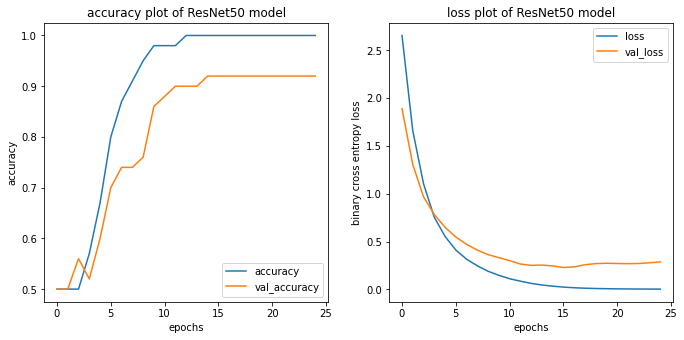

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
fig.tight_layout(pad=3)
ax[0].plot(history.history['accuracy'])
ax[0].plot(history.history['val_accuracy'])
ax[0].legend(['accuracy', 'val_accuracy'])
ax[0].set(title='accuracy plot of ResNet50 model', ylabel='accuracy', xlabel='epochs')
ax[1].plot(history.history['loss'])
ax[1].plot(history.history['val_loss'])
ax[1].legend(['loss', 'val_loss'])
ax[1].set(title='loss plot of ResNet50 model', ylabel='binary cross entropy loss', xlabel='epochs')
plt.show()

In [ ]:
y_hat=[]
y=[]
for i in range(len(pairs_test_x)):
    a=siamese_net_2.predict([np.expand_dims(pairs_test_x[i][0],axis=0),np.expand_dims(pairs_test_x[i][1],axis=0)])
    if a[0][0]>0.5:
      y_hat.append(1)
    else:
      y_hat.append(0)
    y+=[pairs_test_y[i]]
print("accuracy of ResNet50 model is",accuracy_score(y_hat,y))

accuracy of ResNet50 model is 0.92


# EfficientNetB0 based Transfer Learning Model

In [ ]:
input1 = Input((SIZE,SIZE,3))
input2 = Input((SIZE,SIZE,3))
base_model = tf.keras.applications.EfficientNetB0(weights='imagenet',input_shape=(SIZE, SIZE, 3), include_top=False)
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='sigmoid')(x)
x = Dense(512, activation='sigmoid')(x)
for layer in base_model.layers:
    layer.trainable = False
efficientnet_model = Model(inputs=base_model.input, outputs=x)

encoded1 = efficientnet_model(input1)
encoded2 = efficientnet_model(input2)
    
output_layer = Lambda(cosine_similarity)([encoded1,encoded2])
siamese_net_3 = Model(inputs=[input1,input2],outputs=output_layer)

In [ ]:
siamese_net_3.compile(loss = "binary_crossentropy", optimizer="adam", metrics=["accuracy"])
siamese_net_3.summary()

Model: "model_23"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_34 (InputLayer)           [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
input_35 (InputLayer)           [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
model_22 (Functional)           (None, 512)          5886115     input_34[0][0]                   
                                                                 input_35[0][0]                   
__________________________________________________________________________________________________
lambda_11 (Lambda)              (None, 1)            0           model_22[0][0]            

In [ ]:
a=pairs_train_x[:,0]
b=pairs_train_x[:,1]
c=pairs_test_x[:,0]
d=pairs_test_x[:,1]
history=siamese_net_3.fit([a,b], pairs_train_y,batch_size=50, epochs= 30, validation_data=([c,d], pairs_test_y))

Epoch 1/30
2/2 [==============================] - 16s 4s/step - loss: 3.5304 - accuracy: 0.4933 - val_loss: 2.7955 - val_accuracy: 0.5000
Epoch 2/30
2/2 [==============================] - 1s 713ms/step - loss: 2.5082 - accuracy: 0.5000 - val_loss: 2.1223 - val_accuracy: 0.5000
Epoch 3/30
2/2 [==============================] - 1s 706ms/step - loss: 1.7813 - accuracy: 0.5133 - val_loss: 1.5913 - val_accuracy: 0.5000
Epoch 4/30
2/2 [==============================] - 1s 713ms/step - loss: 1.3260 - accuracy: 0.5133 - val_loss: 1.1884 - val_accuracy: 0.5000
Epoch 5/30
2/2 [==============================] - 1s 710ms/step - loss: 0.9277 - accuracy: 0.5267 - val_loss: 0.9006 - val_accuracy: 0.5000
Epoch 6/30
2/2 [==============================] - 1s 715ms/step - loss: 0.7216 - accuracy: 0.5400 - val_loss: 0.6900 - val_accuracy: 0.5400
Epoch 7/30
2/2 [==============================] - 1s 707ms/step - loss: 0.5033 - accuracy: 0.6800 - val_loss: 0.5447 - val_accuracy: 0.6400
Epoch 8/30
2/2 [======

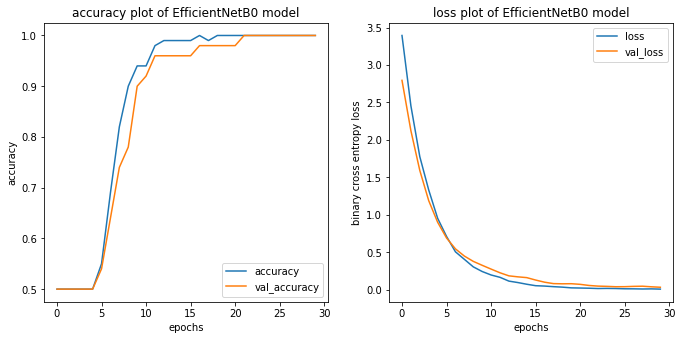

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
fig.tight_layout(pad=3)
ax[0].plot(history.history['accuracy'])
ax[0].plot(history.history['val_accuracy'])
ax[0].legend(['accuracy', 'val_accuracy'])
ax[0].set(title='accuracy plot of EfficientNetB0 model', ylabel='accuracy', xlabel='epochs')
ax[1].plot(history.history['loss'])
ax[1].plot(history.history['val_loss'])
ax[1].legend(['loss', 'val_loss'])
ax[1].set(title='loss plot of EfficientNetB0 model', ylabel='binary cross entropy loss', xlabel='epochs')
plt.show()

In [ ]:
y_hat=[]
y=[]
for i in range(len(pairs_test_x)):
    a=siamese_net_3.predict([np.expand_dims(pairs_test_x[i][0],axis=0),np.expand_dims(pairs_test_x[i][1],axis=0)])
    if a[0][0]>0.5:
      y_hat.append(1)
    else:
      y_hat.append(0)
    y+=[pairs_test_y[i]]
print("accuracy of EfficientNetB0 model is",accuracy_score(y_hat,y))

accuracy of EfficientNetB0 model is 1.0


# Test Predictions
---
Random pairs are chosen from the test set and the predictions for this test from all the 3 models is given

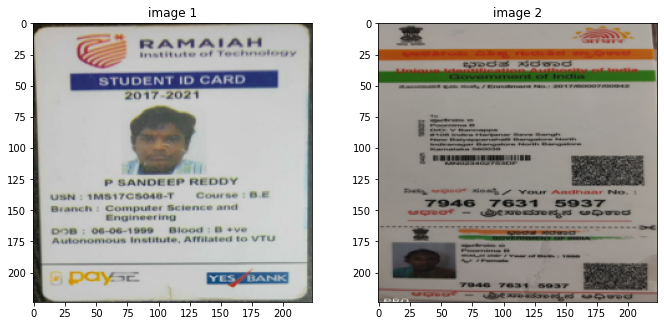

true label for the above pair: 0
prediction from VGG16 model: 0.005690713
prediction from ResNet50 model: 0.026549703
prediction from EfficientNetB3 model: 0.006283993


In [ ]:
rand = random.randrange(0, pairs_test_x.shape[0], 1)
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
fig.tight_layout(pad=3)
ax[0].imshow(pairs_test_x[rand][0])
ax[0].set(title='image 1')
ax[1].imshow(pairs_test_x[rand][1])
ax[1].set(title='image 2')
plt.show()

#predictions
print("true label for the above pair:",pairs_test_y[rand])
print("prediction from VGG16 model:",siamese_net_1.predict([np.expand_dims(pairs_test_x[rand][0],axis=0),np.expand_dims(pairs_test_x[rand][1],axis=0)])[0][0])
print("prediction from ResNet50 model:",siamese_net_2.predict([np.expand_dims(pairs_test_x[rand][0],axis=0),np.expand_dims(pairs_test_x[rand][1],axis=0)])[0][0])
print("prediction from EfficientNetB3 model:",siamese_net_3.predict([np.expand_dims(pairs_test_x[rand][0],axis=0),np.expand_dims(pairs_test_x[rand][1],axis=0)])[0][0])

# Embedings from the models
---
Passing all images through the 3 models to get the individual embeddings

In [ ]:
#embedding of random image from VGG model
vgg_model.predict([np.expand_dims(pairs_test_x[rand][0],axis=0)])

array([[3.51557787e-07, 3.05820862e-07, 4.93418440e-07, 5.39822970e-04,
        2.70111205e-08, 1.21621680e-12, 9.45297182e-01, 1.34490238e-12,
        1.64308167e-05, 1.85259566e-07, 5.05796265e-07, 9.40652251e-01,
        4.99387056e-07, 1.39525500e-05, 2.46147533e-06, 1.96132355e-09,
        9.85000968e-01, 6.10736635e-08, 7.56666125e-08, 5.55789148e-09,
        1.52003586e-05, 1.89136657e-07, 3.92850552e-08, 9.30666738e-06,
        2.57744248e-09, 3.65891495e-08, 1.29450029e-06, 4.12864365e-09,
        2.01686191e-07, 9.22885465e-06, 2.49729908e-07, 7.20509488e-05,
        3.34929057e-10, 8.60366622e-09, 1.05035130e-03, 6.39571056e-07,
        2.36467979e-09, 1.10684382e-03, 2.35702946e-09, 7.24125130e-07,
        1.47836063e-05, 7.75369990e-05, 2.68574222e-04, 2.75203461e-15,
        6.48578407e-06, 2.46671760e-07, 1.87908161e-11, 7.54026344e-13,
        7.92609978e-09, 6.62359453e-05, 1.46538840e-11, 3.09175050e-07,
        1.41505632e-04, 1.86062351e-07, 9.34218480e-09, 2.491622

In [ ]:
#embedding of random image from resnet model
resnet_model.predict([np.expand_dims(pairs_test_x[rand][0],axis=0)]).shape

(1, 512)

In [ ]:
#embedding of random image from efficientnet model
efficientnet_model.predict([np.expand_dims(pairs_test_x[rand][0],axis=0)]).shape

(1, 512)

In [ ]:
vgg_embeddings = []
resnet_embeddings = []
efficientnet_embeddings = []
for i in X:
  efficientnet_embeddings.append(efficientnet_model.predict([np.expand_dims(i,axis=0)])[0])
  resnet_embeddings.append(resnet_model.predict([np.expand_dims(i,axis=0)])[0])
  vgg_embeddings.append(vgg_model.predict([np.expand_dims(i,axis=0)])[0])

In [ ]:
print("no. of embeddings",len(efficientnet_embeddings),len(resnet_embeddings),len(vgg_embeddings))

no. of embeddings 75 75 75


In [ ]:
len(efficientnet_embeddings[0])

512

# Cosine Similarity Matrices
---
Here we are plotting correlation matrices for the cosine similarities of embeddings from each model

* Ideally, items should have high intra class cosine similarity and low inter class cosine similarity

* The representation for the ideal cosine similarity is given at the bottom

In [ ]:
efficientnet_matrix = []
for i in range(len(efficientnet_embeddings)):
  m = []
  for j in range(len(efficientnet_embeddings)):
    m.append(cosine_similarity([tf.constant(efficientnet_embeddings[i]),tf.constant(efficientnet_embeddings[j])]).numpy()[0][0])
  efficientnet_matrix.append(m)

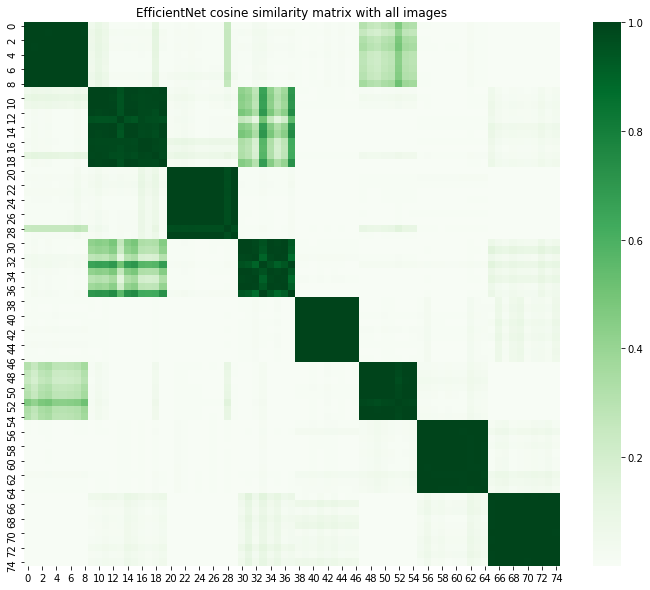

In [ ]:
f, ax = plt.subplots(figsize=(12, 10))
ax.set(title='EfficientNet cosine similarity matrix with all images')
ax = sns.heatmap(np.array(efficientnet_matrix),cmap="Greens")

In [ ]:
resnet_matrix = []
for i in range(len(resnet_embeddings)):
  m = []
  for j in range(len(resnet_embeddings)):
    m.append(cosine_similarity([tf.constant(resnet_embeddings[i]),tf.constant(resnet_embeddings[j])]).numpy()[0][0])
  resnet_matrix.append(m)

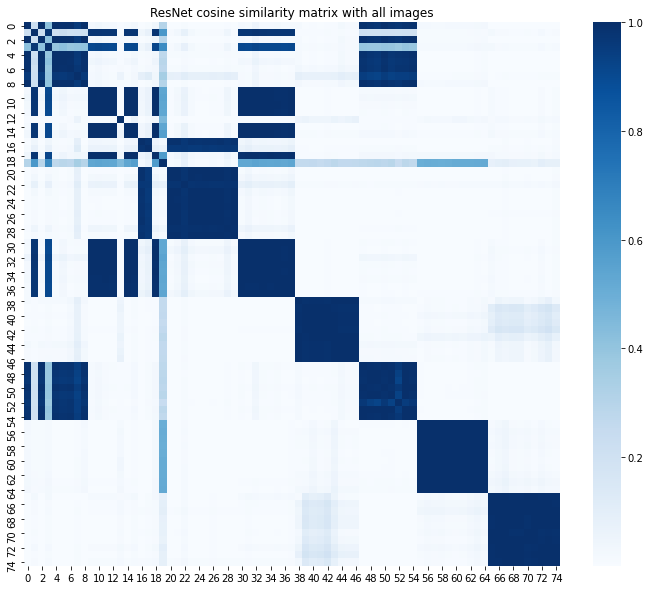

In [ ]:
f, ax = plt.subplots(figsize=(12, 10))
ax.set(title='ResNet cosine similarity matrix with all images')
ax = sns.heatmap(np.array(resnet_matrix),cmap="Blues")

In [ ]:
vgg_matrix = []
for i in range(len(vgg_embeddings)):
  m = []
  for j in range(len(vgg_embeddings)):
    m.append(cosine_similarity([tf.constant(vgg_embeddings[i]),tf.constant(vgg_embeddings[j])]).numpy()[0][0])
  vgg_matrix.append(m)

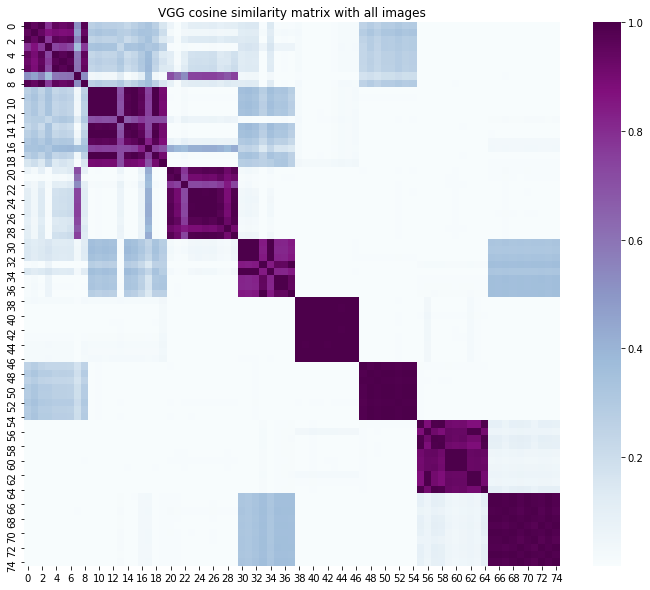

In [ ]:
f, ax = plt.subplots(figsize=(12, 10))
ax.set(title='VGG cosine similarity matrix with all images')
ax = sns.heatmap(np.array(vgg_matrix),cmap="BuPu")

In [ ]:
y = list(Y)
c = Counter(y)
counts = []
for i in c:
  counts.append(c[i])
n = sum(counts)
e = 0 
f = [0]*n
ideal_mat = []
for _ in range(n):
  ideal_mat.append(f[:])
for h in counts:
  for i in range(h):
    for j in range(h):
      ideal_mat[e+i][e+j] = 1
  e+=h

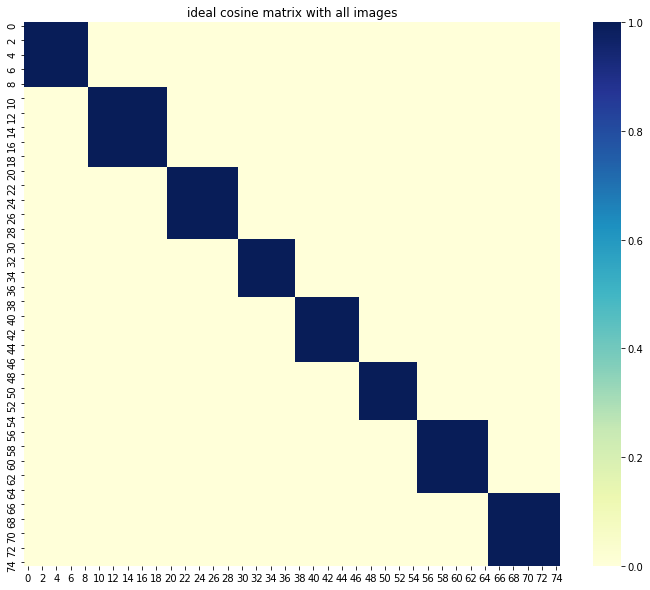

In [ ]:
f, ax = plt.subplots(figsize=(12, 10))
ax.set(title='ideal cosine matrix with all images')
ax = sns.heatmap(np.array(ideal_mat),cmap="YlGnBu")

**EfficientNet gives the best results according to the matrices**

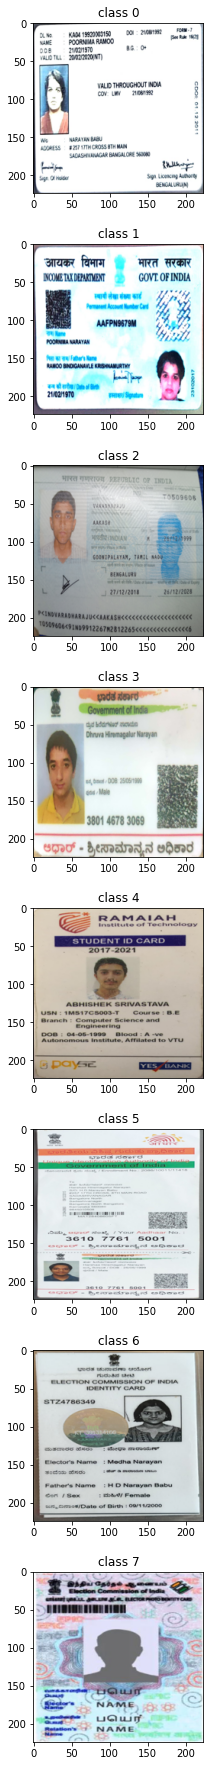

In [ ]:
#printing the order of classes in the cosine similarity matrix
ind = []
for a in range(len(c)):
  ind.append(y.index(a))
fig, ax = plt.subplots(len(c), 1, figsize=(10*len(c), 25))
fig.tight_layout(pad=3)
for i in range(len(c)):
  ax[i].imshow(X[ind[i]])
  ax[i].set(title=class_names[i])
plt.show()

# Average embedding visualization
---
Getting the average value of all the embeddings from each of the classes and then calculating cosine similarity between those average embeddings and the embeddings for each individual image

In [ ]:
def getavg(vects, n):
  avg = []
  for i in range(len(vects[0])):
    s = 0
    for vect in vects:
      s += vect[i]
    s = s/n
    avg.append(s)
  return tf.constant(avg)

In [ ]:
vgg_avgarrays = []
resnet_avgarrays = []
efficientnet_avgarrays = []
e = 0 
for i in counts:
  av1 = getavg(vgg_embeddings[e:e+i], i)
  av2 = getavg(resnet_embeddings[e:e+i], i)
  av3 = getavg(efficientnet_embeddings[e:e+i], i)
  vgg_avgarrays.append(av1)
  resnet_avgarrays.append(av2)
  efficientnet_avgarrays.append(av3)
  e+=i

In [ ]:
vgg_avg_matrix = []
resnet_avg_matrix = []
efficientnet_avg_matrix = []
for i in range(len(vgg_avgarrays)):
  m1 = []
  m2 = []
  m3 = []
  for j in range(len(vgg_embeddings)):
    m1.append(cosine_similarity([vgg_avgarrays[i],tf.constant(vgg_embeddings[j])]).numpy()[0][0])
    m2.append(cosine_similarity([resnet_avgarrays[i],tf.constant(resnet_embeddings[j])]).numpy()[0][0])
    m3.append(cosine_similarity([efficientnet_avgarrays[i],tf.constant(efficientnet_embeddings[j])]).numpy()[0][0])
  vgg_avg_matrix.append(m1)
  resnet_avg_matrix.append(m2)
  efficientnet_avg_matrix.append(m3)

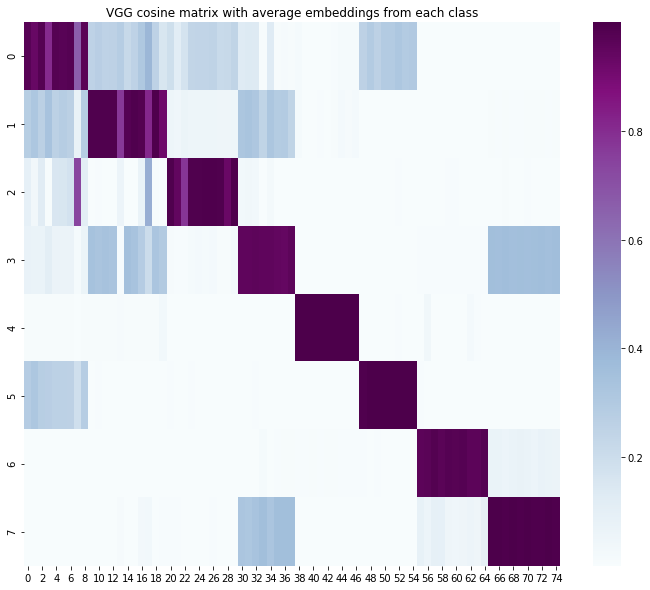

In [ ]:
f, ax = plt.subplots(figsize=(12, 10))
ax.set(title='VGG cosine matrix with average embeddings from each class')
ax = sns.heatmap(np.array(vgg_avg_matrix),cmap="BuPu")

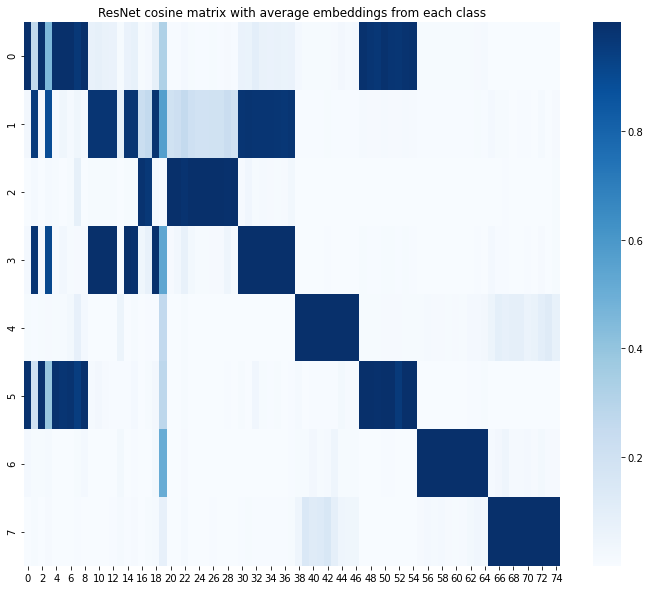

In [ ]:
f, ax = plt.subplots(figsize=(12, 10))
ax.set(title='ResNet cosine matrix with average embeddings from each class')
ax = sns.heatmap(np.array(resnet_avg_matrix),cmap="Blues")

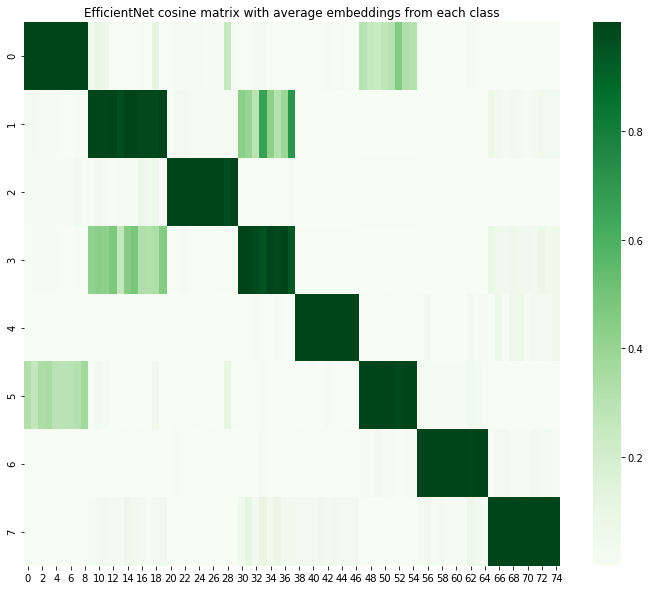

In [ ]:
f, ax = plt.subplots(figsize=(12, 10))
ax.set(title='EfficientNet cosine matrix with average embeddings from each class')
ax = sns.heatmap(np.array(efficientnet_avg_matrix),cmap="Greens")

# Tabulating data to store in database

In [ ]:
table_data = []
for h,i,j,k in zip(Y, vgg_embeddings, resnet_embeddings, efficientnet_embeddings):
  m = [h,i, j, k]
  table_data.append(m)

In [ ]:
m = np.array(table_data)
m.shape

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  """Entry point for launching an IPython kernel.


(75, 4)

In [ ]:
df = pd.DataFrame(data = m, columns = ['class', 'vgg_embeddings', 'resnet_embeddings', 'efficientnet_embeddings'])
df

,class,vgg_embeddings,resnet_embeddings,efficientnet_embeddings
0,0,"[1.3226295e-10, 1.5969323e-06, 2.6955933e-09, ...","[0.0026350191, 0.0071308548, 0.0025010114, 0.0...","[0.00015669895, 0.00055707665, 8.7973705e-05, ..."
1,0,"[3.669329e-11, 2.549081e-07, 2.1919311e-10, 0....","[0.00066278235, 0.0009604677, 0.00049113936, 9...","[0.00026916515, 0.00069547794, 9.437753e-05, 0..."
2,0,"[1.3337372e-11, 8.935298e-07, 2.3488603e-10, 0...","[0.0018189646, 0.0060821073, 0.001939182, 0.00...","[0.00012608226, 0.00034570327, 9.057374e-05, 0..."
3,0,"[6.6799203e-13, 2.3815512e-07, 2.1500511e-11, ...","[0.00072633236, 0.002053674, 0.00065387506, 0....","[0.00013354182, 0.00023739002, 9.2405004e-05, ..."
4,0,"[1.4109022e-10, 1.8700423e-08, 1.108469e-11, 7...","[7.749989e-05, 0.00029801158, 0.00024551456, 0...","[0.00033830033, 0.001094017, 8.545473e-05, 0.0..."
...,...,...,...,...
70,7,"[0.00048202544, 7.48481e-13, 5.948212e-11, 4.0...","[9.187467e-05, 4.286336e-05, 0.0001618031, 0.0...","[0.0006518715, 4.7495455e-06, 0.0001296082, 0...."
71,7,"[8.734169e-05, 2.2640418e-12, 2.1456155e-10, 9...","[5.5233824e-05, 5.913152e-05, 0.00020228274, 0...","[0.00037159742, 4.8410425e-06, 0.00012069729, ..."
72,7,"[3.4414586e-06, 6.2650896e-12, 4.581962e-11, 6...","[9.236026e-05, 6.9772825e-05, 0.00013626795, 0...","[0.0005743642, 3.8186427e-06, 0.00017936439, 0..."
73,7,"[0.000114708804, 6.162038e-14, 6.6203596e-12, ...","[7.08201e-05, 4.95366e-05, 0.00014704399, 0.00...","[0.00027165067, 3.1512825e-06, 0.00010763247, ..."
